In [76]:
%load_ext autoreload
%autoreload 2
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt
from copy import deepcopy
import pandas as pd
from tqdm import tqdm
from collections import defaultdict
from transformers import AutoTokenizer
import pandas as pd
import seaborn as sns
from datasets import Dataset
from os.path import join as oj
import pickle as pkl
import os
import analyze_utils
import dvu
dvu.set_style()
cols_output = ['final_answer_found',
               'final_model_queries', 'final_num_suffixes_checked']

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [169]:
from typing import Dict
import pickle

# load suffix stuff
suffix_results = pickle.load(open('../results/prompt_gen/results_suffix_anli.pkl', 'rb'))
SUFFIX_LEGEND_REMAP = {
    'Single-query': 'Templated suffix (single-output)',
    'Avg suffix': 'Templated suffix',
}
suffix_results['legend'] = suffix_results['use_single_query'].map(SUFFIX_LEGEND_REMAP)
suffix_results['do_reranking'] = False
suffix_results['reciprocal_rank'] = suffix_results['final_answer_pos_initial_token'].map(lambda n: 1/(n+1))


# drop results for other models, n_shots == 10, single-query ones.
suffix_results = suffix_results[
      (suffix_results["checkpoint"] == "EleutherAI/gpt-j-6B")
    & (suffix_results["n_shots"] == 1)
    & (suffix_results["use_single_query"] == "Avg suffix")
]

In [173]:
from typing import Dict


autoprompt_save_dir = '/root/interpretable-autoprompting/results/autoprompt_anli_exps_rerun'

raw_autoprompt_results = analyze_utils.load_results_and_cache_autoprompt_json(autoprompt_save_dir, save_file='r.pkl')
raw_autoprompt_results["legend"] = raw_autoprompt_results.apply(analyze_utils.get_legend__autoprompt, axis=1)
raw_autoprompt_results = raw_autoprompt_results[(raw_autoprompt_results["n_shots"] == 1)]
autoprompt_results = raw_autoprompt_results.groupby(['model_cls', 'task_name', 'n_shots', 'num_learned_tokens']).first().reset_index()

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████▎       | 51/55 [00:00<00:00, 61.73it/s]

skipping /root/interpretable-autoprompting/results/autoprompt_anli_exps_rerun/Sep_26_21_05_dwtgmlqucavl/results.pkl (run still in progress?)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:00<00:00, 71.43it/s]


In [179]:
r = pd.concat((suffix_results, autoprompt_results), axis=0)

## Save prompts to a file

In [182]:
METHOD_REMAP = {
    'autoprompt': 'autoprompt',
    'genetic': 'iprompt'
}
autoprompt_results['method'] = autoprompt_results['model_cls'].map(METHOD_REMAP.get)
anli_prompts = autoprompt_results[autoprompt_results["num_learned_tokens"] == 6].groupby(['model_cls', 'task_name']).first().reset_index()[['method', 'prefixes', 'task_name']].pivot(index='task_name', columns='method')
anli_prompts.to_pickle(open('../results/generalization_acc/anli_prompts__n_shots_1__num_learned_tokens__6.pkl', 'wb'))
anli_prompts

prefixes  \
method                                                                         autoprompt   
task_name                                                                                   
task088_identify_typo_verification                              suff shalt flattthethethe   
task092_check_prime_classification                      seqinterstitial NoAlmost Gork Pub   
task107_splash_question_to_sql                                                        NaN   
task1146_country_capital                                     seat citiz Th city unle quir   
task1147_country_currency                                            Eurothethethethe pes   
task1149_item_check_edible                                               Obs覚醒onoR madeño   
task1191_food_veg_nonveg                                      esの� Jacques cheesetheesame   
task1336_peixian_equity_evaluation_corpus_gende...          middle Five whatMS first char   
task1509_evalution_antonyms                          original opposite Dualthe'completely   
task183_rhyme_generation                                        merry moan tothethe scorn   

                                                                                     
method                                                                      iprompt  
task_name                                                                            
task088_identify_typo_verification                           3 letters, space-separ  
task092_check_prime_classification                              123456Answer : No |  
task107_splash_question_to_sql                            If I delete a column from  
task1146_country_capital                              Correct The following text-to  
task1147_country_currency                                     What's the closest U.  
task1149_item_check_edible                                    Train answer : no_yes  
task1191_food_veg_nonveg                                        SushiAnswer : yes\r  
task1336_peixian_equity_evaluation_corpus_gende...                   “M is a person  
task1509_evalution_antonyms                          Find the word that is opposite  
task183_rhyme_generation                                 Enter two words that rhyme

## Measure best method

In [183]:
TASK_RENAME = {
    'task1191_food_veg_nonveg': 'Check vegetarian',
    'task1509_evalution_antonyms': 'Antonyms',
    'task1147_country_currency': 'Country currency',
    'task088_identify_typo_verification': 'Find typo',
    'task1146_country_capital': 'Country capital',
    'task183_rhyme_generation': 'Rhyme generation',
    'task107_splash_question_to_sql': 'SQL query generation',
    'task1336_peixian_equity_evaluation_corpus_gender_classifier': 'Gender classification',
    'task092_check_prime_classification': 'Check prime',
    'task1149_item_check_edible': 'Check edibility',
}

In [184]:
r['task_name'].value_counts() 

task092_check_prime_classification                             5
task088_identify_typo_verification                             5
task1146_country_capital                                       5
task183_rhyme_generation                                       5
task1336_peixian_equity_evaluation_corpus_gender_classifier    5
task1509_evalution_antonyms                                    5
task1191_food_veg_nonveg                                       5
task1149_item_check_edible                                     5
task1147_country_currency                                      4
task107_splash_question_to_sql                                 3
Name: task_name, dtype: int64

In [190]:
finished_tasks = (r['task_name'].value_counts() == r['task_name'].value_counts().max())
finished_tasks = finished_tasks[finished_tasks].index # take only ones where this is true

task_is_finished = lambda t: (t in finished_tasks)
set(r['task_name'].unique()) - set(finished_tasks)

{'task107_splash_question_to_sql', 'task1147_country_currency'}

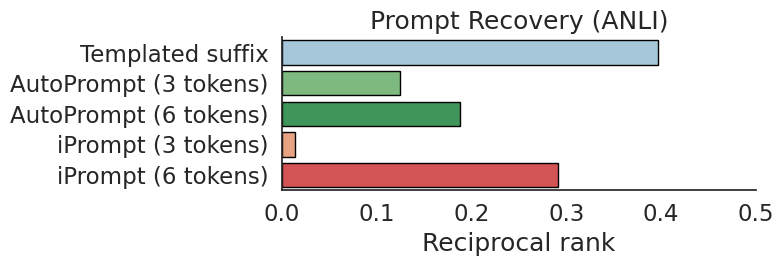

In [193]:
import seaborn as sns
sns.set_theme(font_scale=1.5, style="white")
for metric_key in [
                 'reciprocal_rank',
                #  'final_answer_pos_initial_token',
                #  f'Recall @ {3} suffixes',
                #    f'Recall @ {10} suffixes', 
                #    f'Recall @ {100} suffixes',
                   ]:
    tab = (
        (r[(r['n_shots'] == 1) & r['task_name'].map(task_is_finished)]
            # (mean over templates, task_name)
            .groupby(['legend'])[[metric_key]]
            .mean()
            .reset_index()
        )
    )
    hue_order = analyze_utils.get_hue_order(tab['legend'])
    
    g = sns.catplot(
        kind='bar',
        data=tab,
        x='reciprocal_rank',
        y='legend',
        hue='legend',
        order=hue_order,
        hue_order=hue_order,
        palette=analyze_utils.COLORS,
        edgecolor='black',
        orient='h',
        legend=False,
        # figsize=(15,9)
        dodge=False, # make the bars nice and snug
    )
    # for ax in g.axes.flat:
    #     ax.set_xticks([])
    g.fig.set_figwidth(8)
    g.fig.set_figheight(3)
    plt.xlim((0.0, 0.5))
    plt.xlabel('Reciprocal rank')
    plt.ylabel('')
    plt.title('Prompt Recovery (ANLI)')
    # plt.legend(False)
    plt.tight_layout()
    if metric_key == 'reciprocal_rank':
        plt.savefig('../results/prompt_gen/joint_anli_barplot.pdf', bbox_inches='tight')
        tab.to_pickle(f'../results/prompt_gen/tab_joint_anli_{metric_key}.pkl')
    plt.show()

In [192]:
tab

,legend,reciprocal_rank
0,AutoPrompt (3 tokens),0.125000
1,AutoPrompt (6 tokens),0.187500
2,Templated suffix,0.396980
3,iPrompt (3 tokens),0.014080
4,iPrompt (6 tokens),0.291667


### Plot the best model

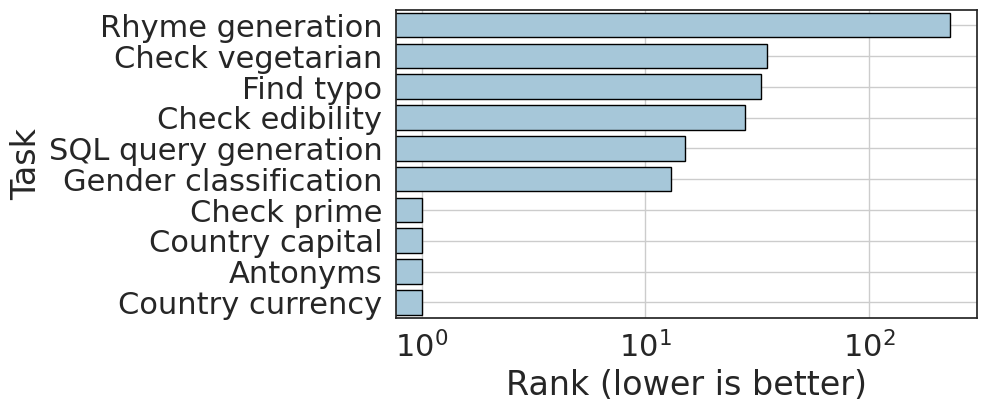

In [187]:
TASK_RENAME = {
    'task1191_food_veg_nonveg': 'Check vegetarian',
    'task1509_evalution_antonyms': 'Antonyms',
    'task1147_country_currency': 'Country currency',
    'task088_identify_typo_verification': 'Find typo',
    'task1146_country_capital': 'Country capital',
    'task183_rhyme_generation': 'Rhyme generation',
    'task107_splash_question_to_sql': 'SQL query generation',
    'task1336_peixian_equity_evaluation_corpus_gender_classifier': 'Gender classification',
    'task092_check_prime_classification': 'Check prime',
    'task1149_item_check_edible': 'Check edibility',
}


r['rank'] = r['final_answer_pos_initial_token'] + 1

def plot_model(legend_name: str, metric: str = 'rank', metric_label: str = 'Rank (lower is better)', logx: bool = True):
    sns.set(style="white", font_scale=2)
    plt.figure(figsize=(7.5, 4))
    model_results = (
        r[(r['legend'] == legend_name) & (r['checkpoint'] == 'EleutherAI/gpt-j-6B')].reset_index()
            .sort_values(by='rank', ascending=False)
    )

    sns.barplot(
        data=model_results, y=model_results['task_name'].map(TASK_RENAME), x=metric, color=analyze_utils.COLORS[legend_name],
        edgecolor='black',
        errorbar=None,
    ) 
    plt.grid()
    if logx: 
        plt.xticks([1, 10, 100], labels=['1', '10', '100'])
        plt.gca().set_xscale('log')
    plt.xlabel(metric_label)
    plt.ylabel('Task')
    
    
# plot_model(legend_name='Prefix, average-output (1-Ex.)')
plot_model(legend_name='Templated suffix')
plt.savefig('../results/prompt_gen/best_rank_math.pdf', bbox_inches='tight')
# plot_model(legend_name='Suffix, average-output decoding (10-Ex.)')

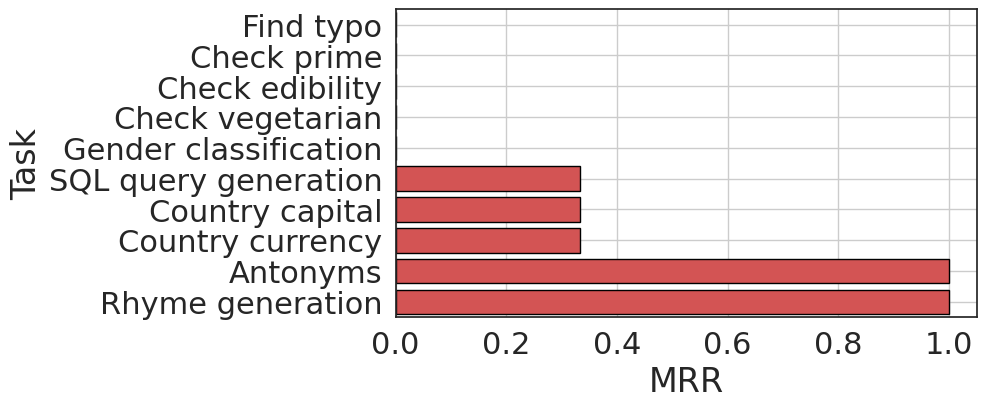

In [73]:
r['rank'] = r['final_answer_pos_initial_token'] + 1    
    
plot_model('iPrompt (6 tokens)', 'reciprocal_rank', 'MRR', logx=False)

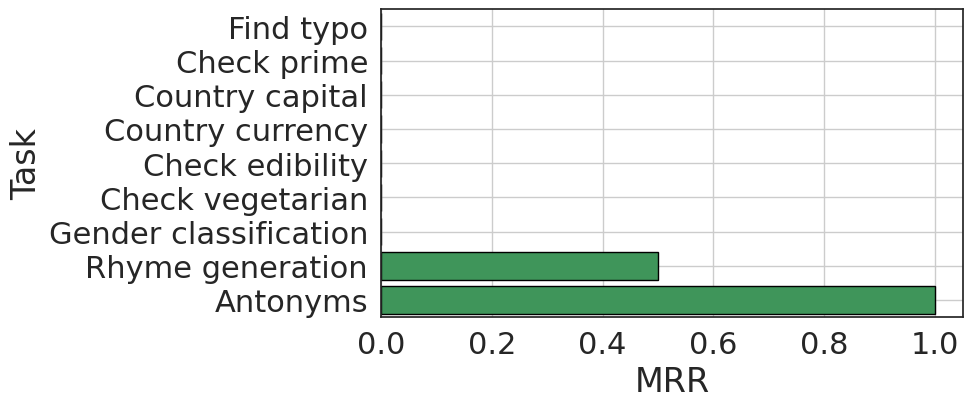

In [74]:
r['rank'] = r['final_answer_pos_initial_token'] + 1    
    
plot_model('AutoPrompt (6 tokens)', 'reciprocal_rank', 'MRR', logx=False)

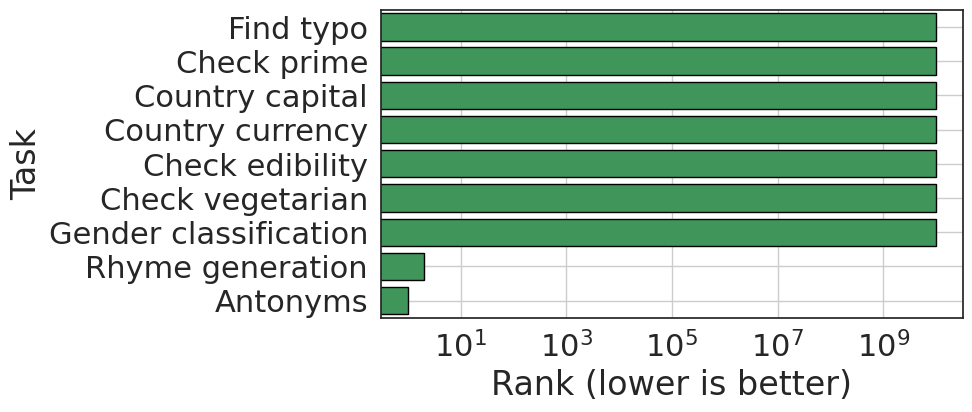

In [75]:
r['rank'] = r['final_answer_pos_initial_token'] + 1
    
    
# plot_model(legend_name='Prefix, average-output (1-Ex.)')
plot_model(legend_name='AutoPrompt (6 tokens)')
# plt.savefig('../results/prompt_gen/best_rank_math.pdf', bbox_inches='tight')
# plot_model(legend_name='Suffix, average-output decoding (10-Ex.)')